https://colab.research.google.com/drive/1KIqp0EcWIaSPpuHj2K-x5_l52N24bI1Y?usp=sharing

In [1]:
!pip install transformers datasets scikit-learn-extra xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 20.4 MB/s 
     |████████████████████████████████| 451 kB 59.1 MB/s 
     |████████████████████████████████| 1.7 MB 20.0 MB/s 
     |████████████████████████████████| 182 kB 24.5 MB/s 
     |████████████████████████████████| 7.6 MB 53.6 MB/s 
     |████████████████████████████████| 115 kB 62.7 MB/s 
     |████████████████████████████████| 212 kB 59.6 MB/s 
     |████████████████████████████████| 127 kB 57.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


# Text Clustering 6 labels

In [2]:
!git clone https://github.com/IndoNLP/nusa-crowd.git

Cloning into 'nusa-crowd'...
remote: Enumerating objects: 4639, done.
remote: Counting objects: 100% (4639/4639), done.
remote: Compressing objects: 100% (1828/1828), done.
remote: Total 4639 (delta 2483), reused 4508 (delta 2389), pack-reused 0
Receiving objects: 100% (4639/4639), 2.02 MiB | 22.22 MiB/s, done.
Resolving deltas: 100% (2483/2483), done.


In [3]:
import sys
sys.path.append('/content/nusa-crowd')

In [4]:
from datasets import load_dataset

path = "nusa-crowd/nusacrowd/nusa_datasets/emotion_id_opinion"
dataset = load_dataset(path)

# see dataset sample:
print(dataset['train'].to_pandas())

Generating train split: 0 examples [00:00, ? examples/s]

Dataset emotion_id_opinion downloaded and prepared to /root/.cache/huggingface/datasets/emotion_id_opinion/emotion_id_opinion_source/1.0.0/a6ab5b7094657b7fedf626821ac093d81dd2595a6fef013c4e4b1e72d695cc24. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

     index                                              tweet  label
0        0                        pagi2 udah di buat emosi :)  Anger
1        1  kok stabilitas negara, memange 10 thn negara t...  Anger
2        2                       dah lah emosi mulu liat emyu  Anger
3        3  aib? bodoh benar! sebelum kata aib itu muncul,...  Anger
4        4                            dih lu yg nyebelin bego  Anger
...    ...                                                ...    ...
7075  7075  pagi saat seisi semesta sujud pada zat yg acap...    Sad
7076  7076  meski engkau yg pergi, meski engkau yg meningg...    Sad
7077  7077                     udah biasa kalah dan tersakiti    Sad
7078  7078  apakabar ku?. apakah baik-baik saja,, tidak, a...    Sad
7079  7079      this user sdg tidak.baik.baik saja sdg stress    Sad

[7080 rows x 3 columns]


In [5]:
dataset['train'][0]

{'index': '0', 'tweet': 'pagi2 udah di buat emosi :)', 'label': 'Anger'}

In [6]:
df = dataset['train'].to_pandas()

In [7]:
df.head()

,index,tweet,label
0,0,pagi2 udah di buat emosi :),Anger
1,1,"kok stabilitas negara, memange 10 thn negara t...",Anger
2,2,dah lah emosi mulu liat emyu,Anger
3,3,"aib? bodoh benar! sebelum kata aib itu muncul,...",Anger
4,4,dih lu yg nyebelin bego,Anger


In [54]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tqdm import tqdm

def count_vectorize(texts,**kwargs):
    vectorizer = CountVectorizer(**kwargs)
    vectorizer.fit(texts)
    vector = vectorizer.transform(texts)
    return vector,vectorizer

def tfidf_vectorize(texts,**kwargs):
    vectorizer = TfidfVectorizer(**kwargs)
    vectorizer.fit(texts)
    vector = vectorizer.transform(texts)
    return vector,vectorizer

def hf_automodel_vectorizer(texts,model,tokenizer,device,batch_size=16,**kwargs):
    model.to(device)
    result = []
    for i in tqdm(range(0,len(texts),batch_size)):
        batch = texts[i:i+batch_size]
        tokenized = tokenizer(batch,return_tensors="pt",padding=True,truncation=True,max_length=512,**kwargs)
        tokenized = tokenized.to(device)
        embedding = model(**tokenized)[0].detach().cpu().numpy()
        result.extend(embedding[:,0].tolist())
    return result

In [9]:
from transformers import AutoModel, AutoTokenizer

model = AutoModel.from_pretrained('indobenchmark/indobert-base-p1')
tokenizer = AutoTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

Downloading:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/498M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [10]:
X_cnt, cnt_v = count_vectorize(df.tweet)
X_tfidf, tfidf_v = tfidf_vectorize(df.tweet)

In [11]:
import torch

In [12]:
tokenizer(df.tweet.values[:5].tolist())

{'input_ids': [[2, 2208, 30378, 2137, 26, 968, 4173, 30472, 30465, 3], [2, 2105, 12302, 664, 30468, 731, 30357, 740, 8992, 664, 6049, 1703, 30468, 816, 7148, 30010, 14073, 30378, 10640, 30468, 26120, 4838, 5, 30468, 10427, 30468, 741, 49, 9760, 21494, 106, 43, 2304, 1400, 30470, 30470, 18275, 578, 1773, 30355, 8099, 3478, 7249, 30470, 30470, 3], [2, 1299, 1389, 4173, 19176, 4961, 822, 3164, 3], [2, 17989, 30477, 7249, 839, 30457, 560, 661, 17989, 137, 1492, 30468, 2311, 2114, 259, 176, 2326, 30470, 1584, 22558, 121, 30457, 843, 954, 29114, 15542, 30360, 23974, 805, 30470, 13463, 436, 1747, 503, 29709, 30, 30457, 387, 954, 186, 5629, 90, 364, 6740, 15750, 24, 30477, 16362, 3031, 24957, 839, 30470, 6117, 387, 9724, 3], [2, 886, 3036, 741, 794, 77, 16400, 872, 30370, 3]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], 

In [13]:
X_hf = hf_automodel_vectorizer(df.tweet.values.tolist(),model,tokenizer,torch.device('cuda:0'))

100%|██████████| 443/443 [00:26<00:00, 16.92it/s]


In [14]:
df.label.unique()

array(['Anger', 'Fear', 'Joy', 'Love', 'Neutral', 'Sad'], dtype=object)

In [15]:
from sklearn.preprocessing import LabelEncoder

In [16]:
le = LabelEncoder().fit(df.label)

In [17]:
y = le.transform(df.label)

In [18]:
n_clusters = len(df.label.unique())

In [19]:
n_clusters

6

In [20]:
from sklearn.cluster import AgglomerativeClustering
from sklearn_extra.cluster import KMedoids

def kmedoids(vectors,n_clusters,**kwargs):
    kmedoids = KMedoids(n_clusters=n_clusters,metric="cosine",**kwargs)
    clusters = kmedoids.fit_predict(vectors)
    return clusters,kmedoids

def agglo_cluster(vectors,n_clusters,**kwargs):
    agglo = AgglomerativeClustering(n_clusters=n_clusters,linkage="average",affinity="cosine")
    clusters = agglo.fit_predict(vectors)
    return clusters,agglo

## Count

In [21]:
cluster_kmedoid_cnt, kmedoid_cnt = kmedoids(X_cnt,n_clusters)

In [22]:
cluster_agglo_cnt, agglo_cnt = agglo_cluster(X_cnt.toarray(),n_clusters)

## Tfidf

In [23]:
cluster_kmedoid_tfidf, kmedoid_tfidf = kmedoids(X_tfidf,n_clusters)

In [24]:
cluster_agglo_tfidf, agglo_tfidf = agglo_cluster(X_tfidf.toarray(),n_clusters)

## HF

In [25]:
cluster_kmedoid_hf, kmedoid_hf = kmedoids(X_hf,n_clusters)

In [26]:
cluster_agglo_hf, agglo_hf = agglo_cluster(X_hf,n_clusters)

## Evaluation

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

In [28]:
le.classes_

array(['Anger', 'Fear', 'Joy', 'Love', 'Neutral', 'Sad'], dtype=object)

In [29]:
import numpy as np

In [30]:
def remap_label(y_true,y_pred):
  assert len(y_true) == len(y_pred)
  unique1 = np.unique(y_pred)
  unique2 = np.unique(y_true)
  assert len(unique1) == len(unique2)
  mapping = {}
  for u1 in unique1:
    labels, counts = np.unique(y_true[y_pred == u1],return_counts=True)
    max_count = -1
    chosen_label = -1
    for i in range(len(labels)):
      if counts[i] > max_count and i not in mapping.values():
        max_count = counts[i]
        chosen_label = i
    mapping[u1] = chosen_label
  return mapping

In [31]:
map_kmedoid_cnt = remap_label(y,cluster_kmedoid_cnt)
map_kmedoid_tfidf = remap_label(y,cluster_kmedoid_tfidf)
map_kmedoid_hf = remap_label(y,cluster_kmedoid_hf)

In [32]:
remapped_kmedoid_cnt = cluster_kmedoid_cnt.copy()
for i in range(len(remapped_kmedoid_cnt)):
  remapped_kmedoid_cnt[i] = map_kmedoid_cnt[remapped_kmedoid_cnt[i]]

remapped_kmedoid_tfidf = cluster_kmedoid_tfidf.copy()
for i in range(len(remapped_kmedoid_tfidf)):
  remapped_kmedoid_tfidf[i] = map_kmedoid_tfidf[remapped_kmedoid_tfidf[i]]

remapped_kmedoid_hf = cluster_kmedoid_hf.copy()
for i in range(len(remapped_kmedoid_hf)):
  remapped_kmedoid_hf[i] = map_kmedoid_hf[remapped_kmedoid_hf[i]]

In [33]:
map_agglo_cnt = remap_label(y,cluster_agglo_cnt)
map_agglo_tfidf = remap_label(y,cluster_agglo_tfidf)
map_agglo_hf = remap_label(y,cluster_agglo_hf)

In [34]:
remapped_agglo_cnt = cluster_agglo_cnt.copy()
for i in range(len(remapped_agglo_cnt)):
  remapped_agglo_cnt[i] = map_agglo_cnt[remapped_agglo_cnt[i]]

remapped_agglo_tfidf = cluster_agglo_tfidf.copy()
for i in range(len(remapped_agglo_tfidf)):
  remapped_agglo_tfidf[i] = map_agglo_tfidf[remapped_agglo_tfidf[i]]

remapped_agglo_hf = cluster_agglo_hf.copy()
for i in range(len(remapped_agglo_hf)):
  remapped_agglo_hf[i] = map_agglo_hf[remapped_agglo_hf[i]]

### K Medoid Count

In [35]:
import seaborn as sns

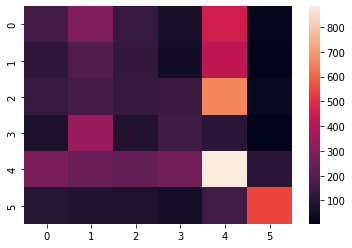

In [36]:
sns.heatmap(confusion_matrix(y,remapped_kmedoid_cnt))

In [37]:
print(classification_report(y,remapped_kmedoid_cnt))

              precision    recall  f1-score   support

           0       0.19      0.15      0.17      1130
           1       0.14      0.21      0.17       911
           2       0.17      0.11      0.13      1275
           3       0.21      0.20      0.20       760
           4       0.33      0.44      0.38      2001
           5       0.76      0.54      0.63      1003

    accuracy                           0.29      7080
   macro avg       0.30      0.27      0.28      7080
weighted avg       0.30      0.29      0.29      7080



### K Medoid Tfidf

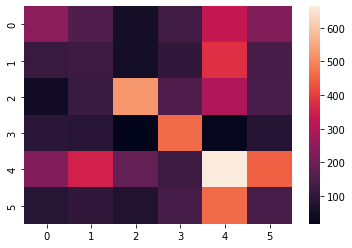

In [38]:
sns.heatmap(confusion_matrix(y,remapped_kmedoid_tfidf))

In [39]:
print(classification_report(y,remapped_kmedoid_tfidf))

              precision    recall  f1-score   support

           0       0.30      0.21      0.25      1130
           1       0.13      0.13      0.13       911
           2       0.58      0.41      0.48      1275
           3       0.42      0.61      0.50       760
           4       0.31      0.33      0.32      2001
           5       0.12      0.14      0.13      1003

    accuracy                           0.30      7080
   macro avg       0.31      0.31      0.30      7080
weighted avg       0.32      0.30      0.31      7080



### K Medoid HF

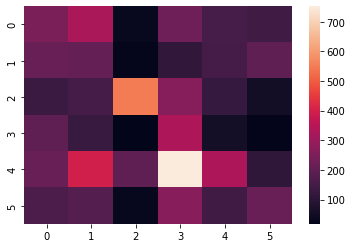

In [40]:
sns.heatmap(confusion_matrix(y,remapped_kmedoid_hf))

In [41]:
print(classification_report(y,remapped_kmedoid_hf))

              precision    recall  f1-score   support

           0       0.21      0.22      0.22      1130
           1       0.15      0.23      0.18       911
           2       0.64      0.43      0.52      1275
           3       0.17      0.44      0.24       760
           4       0.35      0.17      0.22      2001
           5       0.29      0.21      0.25      1003

    accuracy                           0.27      7080
   macro avg       0.30      0.28      0.27      7080
weighted avg       0.33      0.27      0.28      7080



### Agglo Count

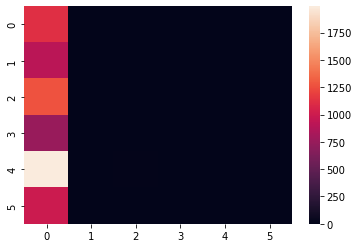

In [42]:
sns.heatmap(confusion_matrix(y,cluster_agglo_cnt))

### Agglo Tfidf

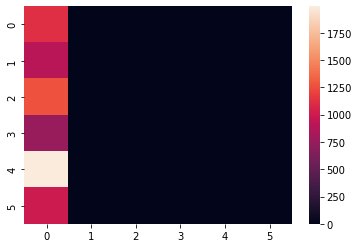

In [43]:
sns.heatmap(confusion_matrix(y,cluster_agglo_tfidf))

### Agglo HF

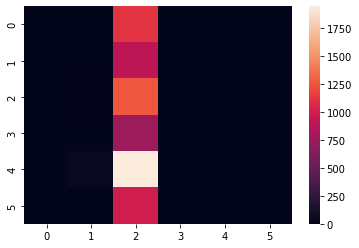

In [44]:
sns.heatmap(confusion_matrix(y,cluster_agglo_hf))

# Text Clustering 2 Labels

In [45]:
path = "nusa-crowd/nusacrowd/nusa_datasets/id_hsd_nofaaulia"
dataset = load_dataset(path)

# see dataset sample:
print(dataset['train'].to_pandas())

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset id_hsd_nofaaulia downloaded and prepared to /root/.cache/huggingface/datasets/id_hsd_nofaaulia/id_hsd_nofaaulia_source/1.0.0/f4f0da66231b2dff4a39c7c40d73634a9773cc4075095988ec818827f03cdafc. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

    index                                               text label
0       0  7 JAM PEMERIKSAAN 2 JAM FOTO2. Luar biasa aura...     0
1       1  Terbitkan Perpres No 20 Tahun 2018, Presiden D...     0
2       2  MURADI: TIM SELEKSI KPU JABAR YANG JUGA STAF A...     0
3       3  Kaos Kampanye PilGub / PilBup / PiLeg / PilPre...     0
4       4  TIMSES JOKOWI MA'RUF AMIN MENGAKUI JOKOWI MARU...     0
..    ...                                                ...   ...
810   810  #HENTIKAN #2019GANTIPRESIDEN DAN HENTIKAN TUDI...     0
811   811  Orang ini memang tidak segagah Prabowo. Badann...     0
812   812  Hai Cebong laknat...kalian kira...kami mengiri...     1
813   813  LEMBAGA SURVEI YANG PREDIKSI TEPAT ANIES SANDI...     0
814   814  BLACK CAMPAIGN SASAR SANDIAGA UNO By: Agung So...     1

[815 rows x 3 columns]


In [46]:
df = pd.concat([dataset['train'].to_pandas(),dataset['test'].to_pandas()])

In [47]:
df.label.unique()

array(['0', '1'], dtype=object)

In [48]:
X_cnt, cnt_v = count_vectorize(df.text)
X_tfidf, tfidf_v = tfidf_vectorize(df.text)

In [52]:
len(df.text.values.tolist())

906

In [55]:
X_hf = hf_automodel_vectorizer(df.text.values.tolist(),model,tokenizer,torch.device('cuda:0'))

100%|██████████| 57/57 [00:29<00:00,  1.92it/s]


In [56]:
le = LabelEncoder().fit(df.label)

In [57]:
y = le.transform(df.label)

In [58]:
n_clusters = len(df.label.unique())

In [59]:
n_clusters

2

## Count

In [60]:
cluster_kmedoid_cnt, kmedoid_cnt = kmedoids(X_cnt,n_clusters)

In [61]:
cluster_agglo_cnt, agglo_cnt = agglo_cluster(X_cnt.toarray(),n_clusters)

## Tfidf

In [62]:
cluster_kmedoid_tfidf, kmedoid_tfidf = kmedoids(X_tfidf,n_clusters)

In [63]:
cluster_agglo_tfidf, agglo_tfidf = agglo_cluster(X_tfidf.toarray(),n_clusters)

## HF

In [64]:
cluster_kmedoid_hf, kmedoid_hf = kmedoids(X_hf,n_clusters)

In [65]:
cluster_agglo_hf, agglo_hf = agglo_cluster(X_hf,n_clusters)

## Evaluation

In [66]:
le.classes_

array(['0', '1'], dtype=object)

In [67]:
map_kmedoid_cnt = remap_label(y,cluster_kmedoid_cnt)
map_kmedoid_tfidf = remap_label(y,cluster_kmedoid_tfidf)
map_kmedoid_hf = remap_label(y,cluster_kmedoid_hf)

In [68]:
remapped_kmedoid_cnt = cluster_kmedoid_cnt.copy()
for i in range(len(remapped_kmedoid_cnt)):
  remapped_kmedoid_cnt[i] = map_kmedoid_cnt[remapped_kmedoid_cnt[i]]

remapped_kmedoid_tfidf = cluster_kmedoid_tfidf.copy()
for i in range(len(remapped_kmedoid_tfidf)):
  remapped_kmedoid_tfidf[i] = map_kmedoid_tfidf[remapped_kmedoid_tfidf[i]]

remapped_kmedoid_hf = cluster_kmedoid_hf.copy()
for i in range(len(remapped_kmedoid_hf)):
  remapped_kmedoid_hf[i] = map_kmedoid_hf[remapped_kmedoid_hf[i]]

In [69]:
map_agglo_cnt = remap_label(y,cluster_agglo_cnt)
map_agglo_tfidf = remap_label(y,cluster_agglo_tfidf)
map_agglo_hf = remap_label(y,cluster_agglo_hf)

In [70]:
remapped_agglo_cnt = cluster_agglo_cnt.copy()
for i in range(len(remapped_agglo_cnt)):
  remapped_agglo_cnt[i] = map_agglo_cnt[remapped_agglo_cnt[i]]

remapped_agglo_tfidf = cluster_agglo_tfidf.copy()
for i in range(len(remapped_agglo_tfidf)):
  remapped_agglo_tfidf[i] = map_agglo_tfidf[remapped_agglo_tfidf[i]]

remapped_agglo_hf = cluster_agglo_hf.copy()
for i in range(len(remapped_agglo_hf)):
  remapped_agglo_hf[i] = map_agglo_hf[remapped_agglo_hf[i]]

### K Medoid Count

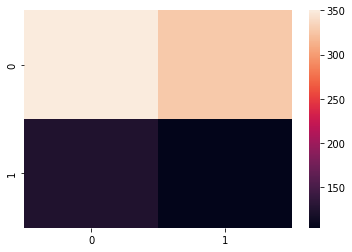

In [71]:
sns.heatmap(confusion_matrix(y,remapped_kmedoid_cnt))

In [72]:
print(classification_report(y,remapped_kmedoid_cnt))

              precision    recall  f1-score   support

           0       0.74      0.52      0.61       677
           1       0.24      0.45      0.32       229

    accuracy                           0.50       906
   macro avg       0.49      0.49      0.46       906
weighted avg       0.61      0.50      0.53       906



### K Medoid Tfidf

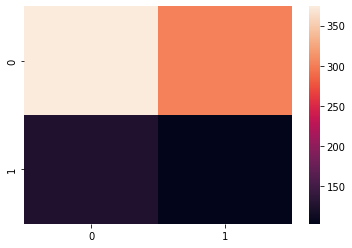

In [73]:
sns.heatmap(confusion_matrix(y,remapped_kmedoid_tfidf))

In [74]:
print(classification_report(y,remapped_kmedoid_tfidf))

              precision    recall  f1-score   support

           0       0.75      0.55      0.64       677
           1       0.25      0.45      0.32       229

    accuracy                           0.53       906
   macro avg       0.50      0.50      0.48       906
weighted avg       0.62      0.53      0.56       906



### K Medoid HF

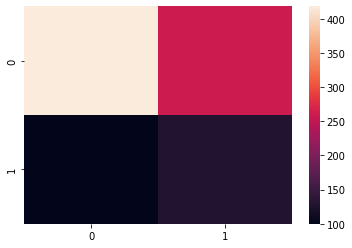

In [75]:
sns.heatmap(confusion_matrix(y,remapped_kmedoid_hf))

In [76]:
print(classification_report(y,remapped_kmedoid_hf))

              precision    recall  f1-score   support

           0       0.81      0.62      0.70       677
           1       0.33      0.56      0.42       229

    accuracy                           0.60       906
   macro avg       0.57      0.59      0.56       906
weighted avg       0.69      0.60      0.63       906



### Agglo Count

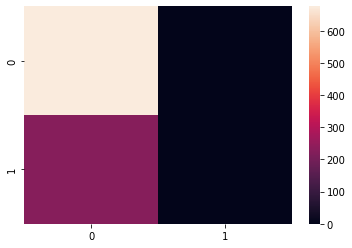

In [77]:
sns.heatmap(confusion_matrix(y,cluster_agglo_cnt))

In [78]:
np.unique(cluster_agglo_cnt,return_counts=True)

(array([0, 1]), array([905,   1]))

### Agglo Tfidf

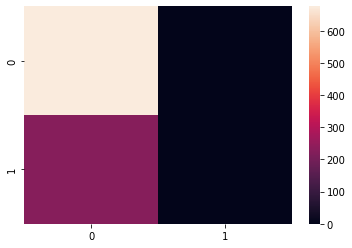

In [79]:
sns.heatmap(confusion_matrix(y,cluster_agglo_tfidf))

In [80]:
np.unique(cluster_agglo_tfidf,return_counts=True)

(array([0, 1]), array([905,   1]))

### Agglo HF

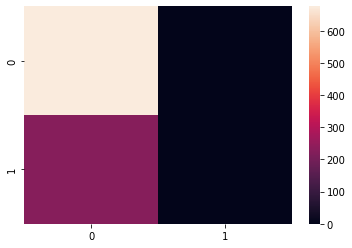

In [81]:
sns.heatmap(confusion_matrix(y,cluster_agglo_hf))

In [82]:
np.unique(cluster_agglo_hf,return_counts=True)

(array([0, 1]), array([905,   1]))

# Text Classification 6 Labels

In [144]:
from datasets import load_dataset

path = "nusa-crowd/nusacrowd/nusa_datasets/emotion_id_opinion"
dataset = load_dataset(path)

# see dataset sample:
print(dataset['train'].to_pandas())

  0%|          | 0/1 [00:00<?, ?it/s]

     index                                              tweet  label
0        0                        pagi2 udah di buat emosi :)  Anger
1        1  kok stabilitas negara, memange 10 thn negara t...  Anger
2        2                       dah lah emosi mulu liat emyu  Anger
3        3  aib? bodoh benar! sebelum kata aib itu muncul,...  Anger
4        4                            dih lu yg nyebelin bego  Anger
...    ...                                                ...    ...
7075  7075  pagi saat seisi semesta sujud pada zat yg acap...    Sad
7076  7076  meski engkau yg pergi, meski engkau yg meningg...    Sad
7077  7077                     udah biasa kalah dan tersakiti    Sad
7078  7078  apakabar ku?. apakah baik-baik saja,, tidak, a...    Sad
7079  7079      this user sdg tidak.baik.baik saja sdg stress    Sad

[7080 rows x 3 columns]


In [145]:
df = dataset['train'].to_pandas()

In [146]:
df.head()

,index,tweet,label
0,0,pagi2 udah di buat emosi :),Anger
1,1,"kok stabilitas negara, memange 10 thn negara t...",Anger
2,2,dah lah emosi mulu liat emyu,Anger
3,3,"aib? bodoh benar! sebelum kata aib itu muncul,...",Anger
4,4,dih lu yg nyebelin bego,Anger


In [147]:
X_cnt, cnt_v = count_vectorize(df.tweet)
X_tfidf, tfidf_v = tfidf_vectorize(df.tweet)
X_hf = hf_automodel_vectorizer(df.tweet.values.tolist(),model,tokenizer,torch.device('cuda:0'))

100%|██████████| 443/443 [00:28<00:00, 15.52it/s]


In [148]:
le = LabelEncoder().fit(df.label)
y = le.transform(df.label)
strat = y

In [149]:
annotated_ratio = [i/10 for i in range(1,10)]

In [150]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

def xgboost(train_vectors,prediction_vectors,target,**kwargs):
    xgb = XGBClassifier(**kwargs)
    xgb.fit(train_vectors,target)
    predictions = xgb.predict(prediction_vectors)
    return predictions,xgb

def adaboost(train_vectors,prediction_vectors,target,**kwargs):
    ada = AdaBoostClassifier(**kwargs)
    ada.fit(train_vectors,target)
    predictions = ada.predict(prediction_vectors)
    return predictions,ada

def svm_classifier(train_vectors,prediction_vectors,target,**kwargs):
    svm = SVC(**kwargs)
    svm.fit(train_vectors,target)
    predictions = svm.predict(prediction_vectors)
    return predictions,svm

## Count

In [151]:
from sklearn.model_selection import train_test_split

for ratio in annotated_ratio:
  X_train, X_test, y_train, y_test = train_test_split(X_cnt, y, test_size=1-ratio, random_state=42, stratify=strat)

  print(f"Classification for annotated from {int(ratio * 100)} % data using XGBoost...")
  predictions, clf = xgboost(X_train,X_test,y_train)
  print(classification_report(y_test,predictions))
  print()

Classification for annotated from 10 % data using XGBoost...
              precision    recall  f1-score   support

           0       0.74      0.57      0.64      1017
           1       0.77      0.68      0.72       820
           2       0.75      0.61      0.67      1147
           3       0.60      0.78      0.68       684
           4       0.57      0.68      0.62      1801
           5       0.69      0.68      0.68       903

    accuracy                           0.66      6372
   macro avg       0.69      0.67      0.67      6372
weighted avg       0.67      0.66      0.66      6372


Classification for annotated from 20 % data using XGBoost...
              precision    recall  f1-score   support

           0       0.73      0.64      0.68       904
           1       0.74      0.75      0.75       729
           2       0.76      0.61      0.68      1020
           3       0.60      0.84      0.70       608
           4       0.61      0.65      0.63      1601
         

In [152]:
for ratio in annotated_ratio:
  X_train, X_test, y_train, y_test = train_test_split(X_cnt, y, test_size=1-ratio, random_state=42, stratify=strat)

  print(f"Classification for annotated from {int(ratio * 100)} % data using Adaboost...")
  predictions, clf = adaboost(X_train,X_test,y_train)
  print(classification_report(y_test,predictions))
  print()

Classification for annotated from 10 % data using Adaboost...
              precision    recall  f1-score   support

           0       0.41      0.06      0.10      1017
           1       0.65      0.60      0.62       820
           2       0.63      0.52      0.57      1147
           3       0.60      0.71      0.65       684
           4       0.43      0.67      0.52      1801
           5       0.57      0.57      0.57       903

    accuracy                           0.52      6372
   macro avg       0.55      0.52      0.51      6372
weighted avg       0.53      0.52      0.50      6372


Classification for annotated from 20 % data using Adaboost...
              precision    recall  f1-score   support

           0       0.22      0.08      0.12       904
           1       0.49      0.10      0.17       729
           2       0.64      0.39      0.48      1020
           3       0.60      0.80      0.69       608
           4       0.40      0.78      0.52      1601
       

In [153]:
for ratio in annotated_ratio:
  X_train, X_test, y_train, y_test = train_test_split(X_cnt, y, test_size=1-ratio, random_state=42, stratify=strat)

  print(f"Classification for annotated from {int(ratio * 100)} % data using SVM Classifier...")
  predictions, clf = svm_classifier(X_train,X_test,y_train)
  print(classification_report(y_test,predictions))
  print()

Classification for annotated from 10 % data using SVM Classifier...
              precision    recall  f1-score   support

           0       0.76      0.34      0.47      1017
           1       0.89      0.42      0.57       820
           2       0.81      0.52      0.63      1147
           3       0.67      0.53      0.59       684
           4       0.41      0.85      0.55      1801
           5       0.79      0.47      0.59       903

    accuracy                           0.57      6372
   macro avg       0.72      0.52      0.57      6372
weighted avg       0.68      0.57      0.57      6372


Classification for annotated from 20 % data using SVM Classifier...
              precision    recall  f1-score   support

           0       0.71      0.46      0.56       904
           1       0.84      0.57      0.68       729
           2       0.81      0.53      0.64      1020
           3       0.65      0.56      0.60       608
           4       0.44      0.80      0.57      

## Tfidf

In [154]:
for ratio in annotated_ratio:
  X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=1-ratio, random_state=42, stratify=strat)

  print(f"Classification for annotated from {int(ratio * 100)} % data using XGBoost...")
  predictions, clf = xgboost(X_train,X_test,y_train)
  print(classification_report(y_test,predictions))
  print()

Classification for annotated from 10 % data using XGBoost...
              precision    recall  f1-score   support

           0       0.71      0.56      0.63      1017
           1       0.75      0.64      0.69       820
           2       0.75      0.59      0.66      1147
           3       0.61      0.73      0.66       684
           4       0.55      0.68      0.60      1801
           5       0.68      0.69      0.68       903

    accuracy                           0.65      6372
   macro avg       0.67      0.65      0.65      6372
weighted avg       0.66      0.65      0.65      6372


Classification for annotated from 20 % data using XGBoost...
              precision    recall  f1-score   support

           0       0.71      0.63      0.67       904
           1       0.75      0.73      0.74       729
           2       0.77      0.61      0.68      1020
           3       0.61      0.79      0.69       608
           4       0.59      0.67      0.62      1601
         

In [155]:
for ratio in annotated_ratio:
  X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=1-ratio, random_state=42, stratify=strat)

  print(f"Classification for annotated from {int(ratio * 100)} % data using Adaboost...")
  predictions, clf = adaboost(X_train,X_test,y_train)
  print(classification_report(y_test,predictions))
  print()

Classification for annotated from 10 % data using Adaboost...
              precision    recall  f1-score   support

           0       0.26      0.06      0.09      1017
           1       0.66      0.56      0.61       820
           2       0.84      0.37      0.52      1147
           3       0.64      0.62      0.63       684
           4       0.40      0.80      0.54      1801
           5       0.74      0.58      0.65       903

    accuracy                           0.52      6372
   macro avg       0.59      0.50      0.51      6372
weighted avg       0.57      0.52      0.50      6372


Classification for annotated from 20 % data using Adaboost...
              precision    recall  f1-score   support

           0       0.28      0.05      0.08       904
           1       0.43      0.33      0.37       729
           2       0.72      0.34      0.46      1020
           3       0.56      0.77      0.65       608
           4       0.39      0.66      0.49      1601
       

In [156]:
for ratio in annotated_ratio:
  X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=1-ratio, random_state=42, stratify=strat)

  print(f"Classification for annotated from {int(ratio * 100)} % data using SVM...")
  predictions, clf = svm_classifier(X_train,X_test,y_train)
  print(classification_report(y_test,predictions))
  print()

Classification for annotated from 10 % data using SVM...
              precision    recall  f1-score   support

           0       0.89      0.17      0.28      1017
           1       0.92      0.17      0.29       820
           2       0.86      0.42      0.56      1147
           3       0.80      0.23      0.35       684
           4       0.34      0.95      0.50      1801
           5       0.91      0.25      0.39       903

    accuracy                           0.45      6372
   macro avg       0.79      0.36      0.40      6372
weighted avg       0.73      0.45      0.42      6372


Classification for annotated from 20 % data using SVM...
              precision    recall  f1-score   support

           0       0.83      0.37      0.51       904
           1       0.89      0.41      0.56       729
           2       0.85      0.48      0.61      1020
           3       0.70      0.47      0.56       608
           4       0.40      0.89      0.55      1601
           5     

## HF

In [157]:
for ratio in annotated_ratio:
  X_train, X_test, y_train, y_test = train_test_split(np.array(X_hf), y, test_size=1-ratio, random_state=42, stratify=strat)

  print(f"Classification for annotated from {int(ratio * 100)} % data using XGBoost...")
  predictions, clf = xgboost(X_train,X_test,y_train)
  print(classification_report(y_test,predictions))
  print()

Classification for annotated from 10 % data using XGBoost...
              precision    recall  f1-score   support

           0       0.55      0.51      0.53      1017
           1       0.58      0.44      0.50       820
           2       0.67      0.61      0.64      1147
           3       0.61      0.50      0.55       684
           4       0.54      0.74      0.62      1801
           5       0.58      0.50      0.54       903

    accuracy                           0.58      6372
   macro avg       0.59      0.55      0.56      6372
weighted avg       0.58      0.58      0.58      6372


Classification for annotated from 20 % data using XGBoost...
              precision    recall  f1-score   support

           0       0.56      0.59      0.57       904
           1       0.64      0.48      0.55       729
           2       0.71      0.60      0.65      1020
           3       0.67      0.56      0.61       608
           4       0.56      0.73      0.63      1601
         

In [158]:
for ratio in annotated_ratio:
  X_train, X_test, y_train, y_test = train_test_split(np.array(X_hf), y, test_size=1-ratio, random_state=42, stratify=strat)

  print(f"Classification for annotated from {int(ratio * 100)} % data using Adaboost...")
  predictions, clf = adaboost(X_train,X_test,y_train)
  print(classification_report(y_test,predictions))
  print()

Classification for annotated from 10 % data using Adaboost...
              precision    recall  f1-score   support

           0       0.41      0.33      0.36      1017
           1       0.29      0.25      0.27       820
           2       0.47      0.51      0.49      1147
           3       0.60      0.22      0.32       684
           4       0.39      0.55      0.46      1801
           5       0.35      0.32      0.33       903

    accuracy                           0.40      6372
   macro avg       0.42      0.36      0.37      6372
weighted avg       0.41      0.40      0.39      6372


Classification for annotated from 20 % data using Adaboost...
              precision    recall  f1-score   support

           0       0.36      0.48      0.41       904
           1       0.32      0.29      0.31       729
           2       0.55      0.57      0.56      1020
           3       0.65      0.41      0.50       608
           4       0.44      0.44      0.44      1601
       

In [159]:
for ratio in annotated_ratio:
  X_train, X_test, y_train, y_test = train_test_split(np.array(X_hf), y, test_size=1-ratio, random_state=42, stratify=strat)

  print(f"Classification for annotated from {int(ratio * 100)} % data using SVM...")
  predictions, clf = svm_classifier(X_train,X_test,y_train)
  print(classification_report(y_test,predictions))
  print()

Classification for annotated from 10 % data using SVM...
              precision    recall  f1-score   support

           0       0.57      0.48      0.52      1017
           1       0.67      0.41      0.51       820
           2       0.75      0.61      0.67      1147
           3       0.67      0.55      0.61       684
           4       0.50      0.81      0.62      1801
           5       0.73      0.48      0.58       903

    accuracy                           0.60      6372
   macro avg       0.65      0.56      0.58      6372
weighted avg       0.63      0.60      0.59      6372


Classification for annotated from 20 % data using SVM...
              precision    recall  f1-score   support

           0       0.60      0.65      0.62       904
           1       0.75      0.53      0.62       729
           2       0.77      0.60      0.68      1020
           3       0.68      0.60      0.64       608
           4       0.56      0.77      0.65      1601
           5     

# Text Classification 2 Labels

In [162]:
path = "nusa-crowd/nusacrowd/nusa_datasets/id_hsd_nofaaulia"
dataset = load_dataset(path)

# see dataset sample:
print(dataset['train'].to_pandas())

  0%|          | 0/2 [00:00<?, ?it/s]

    index                                               text label
0       0  7 JAM PEMERIKSAAN 2 JAM FOTO2. Luar biasa aura...     0
1       1  Terbitkan Perpres No 20 Tahun 2018, Presiden D...     0
2       2  MURADI: TIM SELEKSI KPU JABAR YANG JUGA STAF A...     0
3       3  Kaos Kampanye PilGub / PilBup / PiLeg / PilPre...     0
4       4  TIMSES JOKOWI MA'RUF AMIN MENGAKUI JOKOWI MARU...     0
..    ...                                                ...   ...
810   810  #HENTIKAN #2019GANTIPRESIDEN DAN HENTIKAN TUDI...     0
811   811  Orang ini memang tidak segagah Prabowo. Badann...     0
812   812  Hai Cebong laknat...kalian kira...kami mengiri...     1
813   813  LEMBAGA SURVEI YANG PREDIKSI TEPAT ANIES SANDI...     0
814   814  BLACK CAMPAIGN SASAR SANDIAGA UNO By: Agung So...     1

[815 rows x 3 columns]


In [164]:
df = pd.concat([dataset['train'].to_pandas(),dataset['test'].to_pandas()])

In [165]:
X_cnt, cnt_v = count_vectorize(df.text)
X_tfidf, tfidf_v = tfidf_vectorize(df.text)

In [166]:
X_hf = hf_automodel_vectorizer(df.text.values.tolist(),model,tokenizer,torch.device('cuda:0'))

100%|██████████| 57/57 [00:31<00:00,  1.83it/s]


In [167]:
le = LabelEncoder().fit(df.label)
y = le.transform(df.label)
strat = y

## Count

In [168]:
for ratio in annotated_ratio:
  X_train, X_test, y_train, y_test = train_test_split(X_cnt, y, test_size=1-ratio, random_state=42, stratify=strat)

  print(f"Classification for annotated from {int(ratio * 100)} % data using XGBoost...")
  predictions, clf = xgboost(X_train,X_test,y_train)
  print(classification_report(y_test,predictions))
  print()

Classification for annotated from 10 % data using XGBoost...
              precision    recall  f1-score   support

           0       0.77      0.94      0.85       610
           1       0.50      0.17      0.25       206

    accuracy                           0.75       816
   macro avg       0.64      0.55      0.55       816
weighted avg       0.70      0.75      0.70       816


Classification for annotated from 20 % data using XGBoost...
              precision    recall  f1-score   support

           0       0.80      0.94      0.86       542
           1       0.63      0.28      0.39       183

    accuracy                           0.78       725
   macro avg       0.71      0.61      0.62       725
weighted avg       0.75      0.78      0.74       725


Classification for annotated from 30 % data using XGBoost...
              precision    recall  f1-score   support

           0       0.80      0.97      0.88       474
           1       0.75      0.28      0.41       16

In [169]:
for ratio in annotated_ratio:
  X_train, X_test, y_train, y_test = train_test_split(X_cnt, y, test_size=1-ratio, random_state=42, stratify=strat)

  print(f"Classification for annotated from {int(ratio * 100)} % data using Adaboost...")
  predictions, clf = adaboost(X_train,X_test,y_train)
  print(classification_report(y_test,predictions))
  print()

Classification for annotated from 10 % data using Adaboost...
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       610
           1       0.42      0.29      0.34       206

    accuracy                           0.72       816
   macro avg       0.60      0.58      0.58       816
weighted avg       0.69      0.72      0.70       816


Classification for annotated from 20 % data using Adaboost...
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       542
           1       0.47      0.42      0.44       183

    accuracy                           0.73       725
   macro avg       0.64      0.63      0.63       725
weighted avg       0.72      0.73      0.73       725


Classification for annotated from 30 % data using Adaboost...
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       474
           1       0.51      0.38      0.44      

In [170]:
for ratio in annotated_ratio:
  X_train, X_test, y_train, y_test = train_test_split(X_cnt, y, test_size=1-ratio, random_state=42, stratify=strat)

  print(f"Classification for annotated from {int(ratio * 100)} % data using SVM Classifier...")
  predictions, clf = svm_classifier(X_train,X_test,y_train)
  print(classification_report(y_test,predictions))
  print()

Classification for annotated from 10 % data using SVM Classifier...
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       610
           1       0.00      0.00      0.00       206

    accuracy                           0.75       816
   macro avg       0.37      0.50      0.43       816
weighted avg       0.56      0.75      0.64       816


Classification for annotated from 20 % data using SVM Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.75      1.00      0.86       542
           1       0.00      0.00      0.00       183

    accuracy                           0.75       725
   macro avg       0.37      0.50      0.43       725
weighted avg       0.56      0.75      0.64       725


Classification for annotated from 30 % data using SVM Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.75      1.00      0.85       474
           1       0.00      0.00      0.00       161

    accuracy                           0.75       635
   macro avg       0.37      0.50      0.43       635
weighted avg       0.56      0.75      0.64       635


Classification for annotated from 40 % data using SVM Classifier...
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       406
           1       1.00      0.01      0.03       138

    accuracy                           0.75       544
   macro avg       0.87      0.51      0.44       544
weighted avg       0.81      0.75      0.65       544


Classification for annotated from 50 % data using SVM Classifier...
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       339
           1       0.80      0.04      0.07       114

    accuracy                           0.75 

## Tfidf

In [171]:
for ratio in annotated_ratio:
  X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=1-ratio, random_state=42, stratify=strat)

  print(f"Classification for annotated from {int(ratio * 100)} % data using XGBoost...")
  predictions, clf = xgboost(X_train,X_test,y_train)
  print(classification_report(y_test,predictions))
  print()

Classification for annotated from 10 % data using XGBoost...
              precision    recall  f1-score   support

           0       0.76      0.96      0.85       610
           1       0.48      0.11      0.18       206

    accuracy                           0.75       816
   macro avg       0.62      0.54      0.52       816
weighted avg       0.69      0.75      0.68       816


Classification for annotated from 20 % data using XGBoost...
              precision    recall  f1-score   support

           0       0.78      0.94      0.86       542
           1       0.57      0.22      0.32       183

    accuracy                           0.76       725
   macro avg       0.68      0.58      0.59       725
weighted avg       0.73      0.76      0.72       725


Classification for annotated from 30 % data using XGBoost...
              precision    recall  f1-score   support

           0       0.79      0.97      0.87       474
           1       0.71      0.23      0.35       16

In [172]:
for ratio in annotated_ratio:
  X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=1-ratio, random_state=42, stratify=strat)

  print(f"Classification for annotated from {int(ratio * 100)} % data using Adaboost...")
  predictions, clf = adaboost(X_train,X_test,y_train)
  print(classification_report(y_test,predictions))
  print()

Classification for annotated from 10 % data using Adaboost...
              precision    recall  f1-score   support

           0       0.78      0.90      0.83       610
           1       0.44      0.23      0.30       206

    accuracy                           0.73       816
   macro avg       0.61      0.56      0.57       816
weighted avg       0.69      0.73      0.70       816


Classification for annotated from 20 % data using Adaboost...
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       542
           1       0.45      0.44      0.44       183

    accuracy                           0.72       725
   macro avg       0.63      0.63      0.63       725
weighted avg       0.72      0.72      0.72       725


Classification for annotated from 30 % data using Adaboost...
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       474
           1       0.52      0.38      0.44      

In [173]:
for ratio in annotated_ratio:
  X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=1-ratio, random_state=42, stratify=strat)

  print(f"Classification for annotated from {int(ratio * 100)} % data using SVM...")
  predictions, clf = svm_classifier(X_train,X_test,y_train)
  print(classification_report(y_test,predictions))
  print()

Classification for annotated from 10 % data using SVM...
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       610
           1       0.00      0.00      0.00       206

    accuracy                           0.75       816
   macro avg       0.37      0.50      0.43       816
weighted avg       0.56      0.75      0.64       816


Classification for annotated from 20 % data using SVM...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0       0.75      1.00      0.86       542
           1       0.00      0.00      0.00       183

    accuracy                           0.75       725
   macro avg       0.37      0.50      0.43       725
weighted avg       0.56      0.75      0.64       725


Classification for annotated from 30 % data using SVM...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.75      1.00      0.85       474
           1       0.00      0.00      0.00       161

    accuracy                           0.75       635
   macro avg       0.37      0.50      0.43       635
weighted avg       0.56      0.75      0.64       635


Classification for annotated from 40 % data using SVM...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.75      1.00      0.85       406
           1       0.00      0.00      0.00       138

    accuracy                           0.75       544
   macro avg       0.37      0.50      0.43       544
weighted avg       0.56      0.75      0.64       544


Classification for annotated from 50 % data using SVM...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.75      1.00      0.86       339
           1       0.00      0.00      0.00       114

    accuracy                           0.75       453
   macro avg       0.37      0.50      0.43       453
weighted avg       0.56      0.75      0.64       453


Classification for annotated from 60 % data using SVM...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.75      1.00      0.85       271
           1       0.00      0.00      0.00        92

    accuracy                           0.75       363
   macro avg       0.37      0.50      0.43       363
weighted avg       0.56      0.75      0.64       363


Classification for annotated from 70 % data using SVM...
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       203
           1       1.00      0.01      0.03        69

    accuracy                           0.75       272
   macro avg       0.87      0.51      0.44       272
weighted avg       0.81      0.75      0.65       272


Classification for annotated from 80 % data using SVM...
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       136
           1       1.00      0.04      0.08        46

    accuracy                           0.76       182
   macro avg

## HF

In [174]:
for ratio in annotated_ratio:
  X_train, X_test, y_train, y_test = train_test_split(np.array(X_hf), y, test_size=1-ratio, random_state=42, stratify=strat)

  print(f"Classification for annotated from {int(ratio * 100)} % data using XGBoost...")
  predictions, clf = xgboost(X_train,X_test,y_train)
  print(classification_report(y_test,predictions))
  print()

Classification for annotated from 10 % data using XGBoost...
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       610
           1       0.60      0.36      0.45       206

    accuracy                           0.78       816
   macro avg       0.71      0.64      0.66       816
weighted avg       0.76      0.78      0.76       816


Classification for annotated from 20 % data using XGBoost...
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       542
           1       0.72      0.40      0.52       183

    accuracy                           0.81       725
   macro avg       0.77      0.68      0.70       725
weighted avg       0.80      0.81      0.79       725


Classification for annotated from 30 % data using XGBoost...
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       474
           1       0.76      0.48      0.59       16

In [175]:
for ratio in annotated_ratio:
  X_train, X_test, y_train, y_test = train_test_split(np.array(X_hf), y, test_size=1-ratio, random_state=42, stratify=strat)

  print(f"Classification for annotated from {int(ratio * 100)} % data using Adaboost...")
  predictions, clf = adaboost(X_train,X_test,y_train)
  print(classification_report(y_test,predictions))
  print()

Classification for annotated from 10 % data using Adaboost...
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       610
           1       0.66      0.39      0.49       206

    accuracy                           0.79       816
   macro avg       0.74      0.66      0.68       816
weighted avg       0.78      0.79      0.77       816


Classification for annotated from 20 % data using Adaboost...
              precision    recall  f1-score   support

           0       0.84      0.91      0.88       542
           1       0.66      0.49      0.56       183

    accuracy                           0.81       725
   macro avg       0.75      0.70      0.72       725
weighted avg       0.80      0.81      0.80       725


Classification for annotated from 30 % data using Adaboost...
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       474
           1       0.67      0.57      0.62      

In [176]:
for ratio in annotated_ratio:
  X_train, X_test, y_train, y_test = train_test_split(np.array(X_hf), y, test_size=1-ratio, random_state=42, stratify=strat)

  print(f"Classification for annotated from {int(ratio * 100)} % data using SVM...")
  predictions, clf = svm_classifier(X_train,X_test,y_train)
  print(classification_report(y_test,predictions))
  print()

Classification for annotated from 10 % data using SVM...
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       610
           1       0.00      0.00      0.00       206

    accuracy                           0.75       816
   macro avg       0.37      0.50      0.43       816
weighted avg       0.56      0.75      0.64       816


Classification for annotated from 20 % data using SVM...
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       542
           1       1.00      0.02      0.04       183

    accuracy                           0.75       725
   macro avg       0.88      0.51      0.45       725
weighted avg       0.81      0.75      0.65       725


Classification for annotated from 30 % data using SVM...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.76      0.99      0.86       474
           1       0.83      0.09      0.17       161

    accuracy                           0.77       635
   macro avg       0.80      0.54      0.52       635
weighted avg       0.78      0.77      0.69       635


Classification for annotated from 40 % data using SVM...
              precision    recall  f1-score   support

           0       0.82      0.98      0.89       406
           1       0.83      0.36      0.50       138

    accuracy                           0.82       544
   macro avg       0.82      0.67      0.69       544
weighted avg       0.82      0.82      0.79       544


Classification for annotated from 50 % data using SVM...
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       339
           1       0.80      0.46      0.59       114

    accuracy                           0.84       453
   macro avg